# Terrain Classification - Mahsa's Power Data
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    elif 'Synthesis' in _label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD', 'PSDLog']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/new_setup/set_power/*.csv')

# Remove 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Mahsa' not in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use at time range
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time',]

In [7]:
# List all datasets
dataset_labels

['Middle_PowerGravelStraightMahsa_Module6050',
 'Middle_PowerConcreteDonutMahsa_Module6050',
 'Middle_PowerGrassF8Mahsa_Module6050',
 'Middle_PowerLinoleumDonutMahsa_Module6050',
 'Middle_PowerSidewalkStraightMahsa_Module6050',
 'Middle_PowerLinoleumStraightMahsa_Module6050',
 'Middle_ConcreteDonutMahsa_Module6050',
 'Middle_PowerCarpetF8Mahsa_Module6050',
 'Middle_PowerLinoleumF8Mahsa_Module6050',
 'Middle_PowerCarpetStraightMahsa_Module6050',
 'Middle_PowerAsphaltStraightMahsa_Module6050',
 'Middle_PowerCarpetDonutMahsa_Module6050',
 'Middle_PowerConcreteStraightMahsa_Module6050',
 'Middle_PowerGrassStraightMahsa_Module6050',
 'Middle_PowerGravelDonutMahsa_Module6050',
 'Middle_PowerConcreteF8Mahsa_Module6050',
 'Middle_PowerGravelF8Mahsa_Module6050',
 'Middle_PowerSidewalkDonutMahsa_Module6050',
 'Middle_PowerAsphaltF8Mahsa_Module6050',
 'Middle_PowerGrassDonutMahsa_Module6050',
 'Middle_PowerAphaltDonutMahsa_Module6050',
 'Middle_PowerSidewalkF8Mahsa_Module6050']

In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
1995,-8.420902,-6.297153,9.694913,-0.751930,-0.417579,0.284773,6.650059,1.565128e+09
1996,19.669512,6.615338,-10.068956,0.065860,-0.124826,0.058349,6.653251,1.565128e+09
1997,-12.532688,-1.272967,4.206147,-0.133393,-0.137079,0.112691,6.656236,1.565128e+09
1998,6.706731,-4.014956,-0.839591,-0.386988,-0.188757,0.124678,6.660009,1.565128e+09
1999,-1.818578,2.161103,-0.542642,0.484878,0.208950,-0.280222,6.663197,1.565128e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

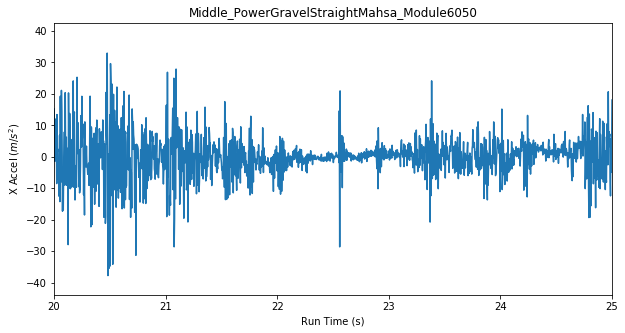

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'X Accel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

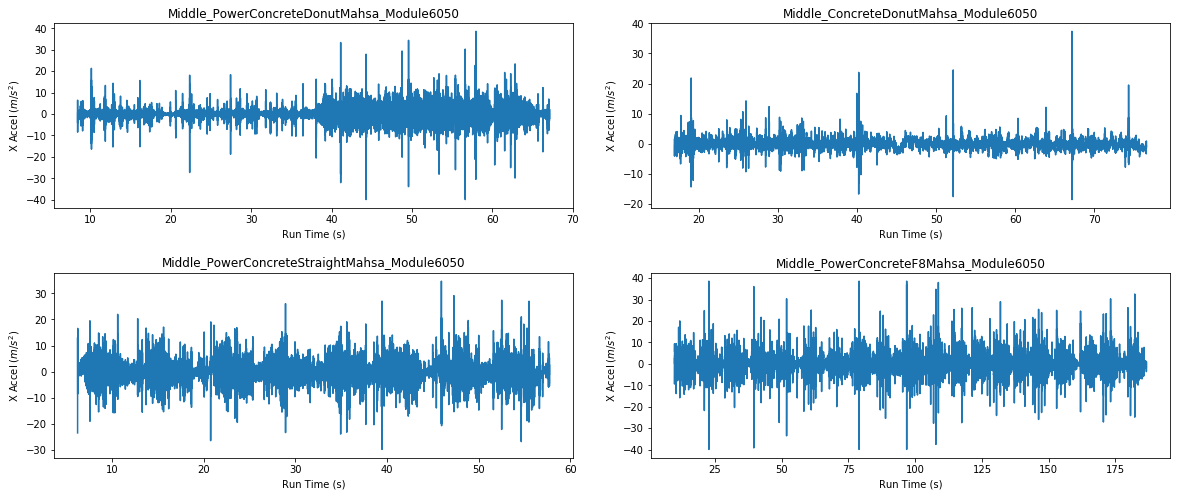

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='X Accel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 22
Shape of first dataset: (18916, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

In [23]:
def get_n_data_col(label):
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label format')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

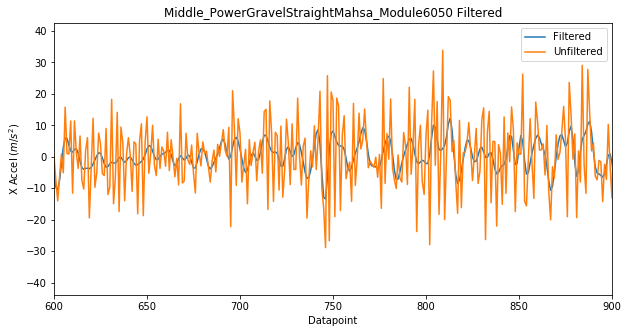

In [25]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [26]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 22
Shape of first filtered dataset: (18916, 8)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-8.422158,-6.297548,9.695698,-0.751967,-0.417586,0.284786,6.650059,1.565128e+09
1,-0.730606,-1.480768,1.897855,-0.333722,-0.245142,0.158565,6.653251,1.565128e+09
2,3.081305,0.782925,-2.154910,-0.072454,-0.112564,0.061026,6.656236,1.565128e+09
3,2.762701,0.480306,-2.089783,0.010492,-0.034530,0.005225,6.660009,1.565128e+09
4,0.959843,-0.455955,-0.395533,0.010754,-0.002285,-0.015217,6.663197,1.565128e+09


<Figure size 432x288 with 0 Axes>

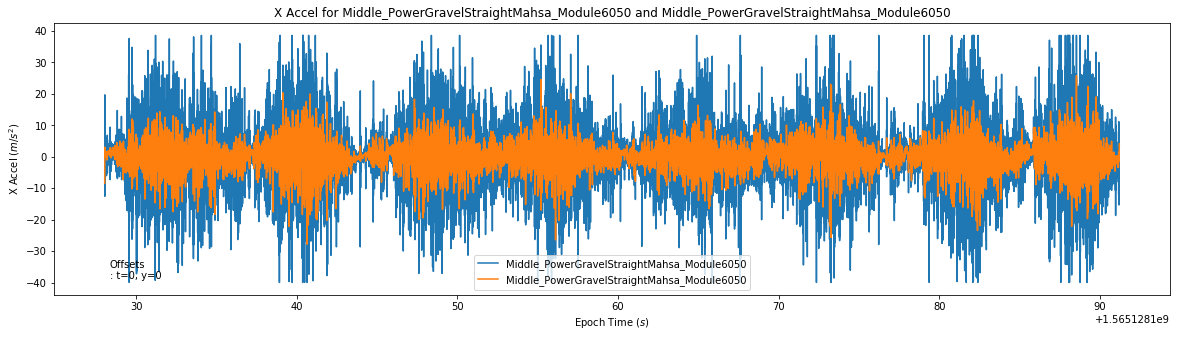

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

### Part (c) - Integrating Data from Three Modules

In [31]:
# Go through Left and Right datasets and integrate into one dataset
'''
for terrain in terrains:
    for movement in movements:
        # Identifier at end of label
        label_suffix = terrain + movement + '_Module'
        
        # Set index to epoch time for easier time alignment
        left = datasets['Left_' + label_suffix].set_index('Epoch Time')
        right = datasets['Right_' + label_suffix].set_index('Epoch Time')
        middle = datasets['Middle_' + label_suffix + '6050'].set_index('Epoch Time')
        synthesis = datasets['Synthesis_' + label_suffix].set_index('Epoch Time')
        
        # Join the wheel data columns, only where they overlap in Epoch Time
        dataset_wheels = pd.concat([left, right], axis=1, join='inner')
        dataset_wheels = dataset_wheels.reset_index()
        
        # Save as a csv and add to dataset dictionary
        wheels_label = 'Wheels_' + label_suffix
        dataset_wheels.to_csv('imu_data/' + wheels_label + '.csv', index=False)
        datasets.update({wheels_label: dataset_wheels})
        
        # Join data from all the "placements", only where they overlap in Epoch Time
        dataset_all = pd.concat([left, right, middle, synthesis], axis=1, join='inner')
        dataset_all = dataset_all.reset_index()
        
        # Save as csv and add to dictionary
        all_label = 'All_' + label_suffix
        dataset_all.to_csv('imu_data/' + all_label + '.csv')
        datasets.update({all_label: dataset_all})
'''

'\nfor terrain in terrains:\n    for movement in movements:\n        # Identifier at end of label\n        label_suffix = terrain + movement + \'_Module\'\n        \n        # Set index to epoch time for easier time alignment\n        left = datasets[\'Left_\' + label_suffix].set_index(\'Epoch Time\')\n        right = datasets[\'Right_\' + label_suffix].set_index(\'Epoch Time\')\n        middle = datasets[\'Middle_\' + label_suffix + \'6050\'].set_index(\'Epoch Time\')\n        synthesis = datasets[\'Synthesis_\' + label_suffix].set_index(\'Epoch Time\')\n        \n        # Join the wheel data columns, only where they overlap in Epoch Time\n        dataset_wheels = pd.concat([left, right], axis=1, join=\'inner\')\n        dataset_wheels = dataset_wheels.reset_index()\n        \n        # Save as a csv and add to dataset dictionary\n        wheels_label = \'Wheels_\' + label_suffix\n        dataset_wheels.to_csv(\'imu_data/\' + wheels_label + \'.csv\', index=False)\n        datasets.up

In [32]:
# Only process new integrated data for now
#datasets = {label: dataset for label, dataset in datasets.items() if 'All' in label or 'Wheels' in label}
#dataset_labels = list(datasets.keys())

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [33]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [34]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 22
Num of windows in first dataset: 63
Shape of individual window: (300, 8)


In [35]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
295,-3.186056,-1.624574,-4.399695,0.045358,-0.061462,0.233249,7.640015,1.565128e+09
296,-2.933711,-1.135551,-4.363608,-0.031586,0.235900,0.232390,7.643154,1.565128e+09
297,-1.398776,0.023849,-3.213193,-0.060863,0.415368,0.216338,7.646185,1.565128e+09
298,0.657583,1.352529,-1.426763,-0.029369,0.429018,0.195390,7.650016,1.565128e+09
299,2.374317,2.127631,0.428597,0.036679,0.278333,0.186202,7.653136,1.565128e+09


<Figure size 432x288 with 0 Axes>

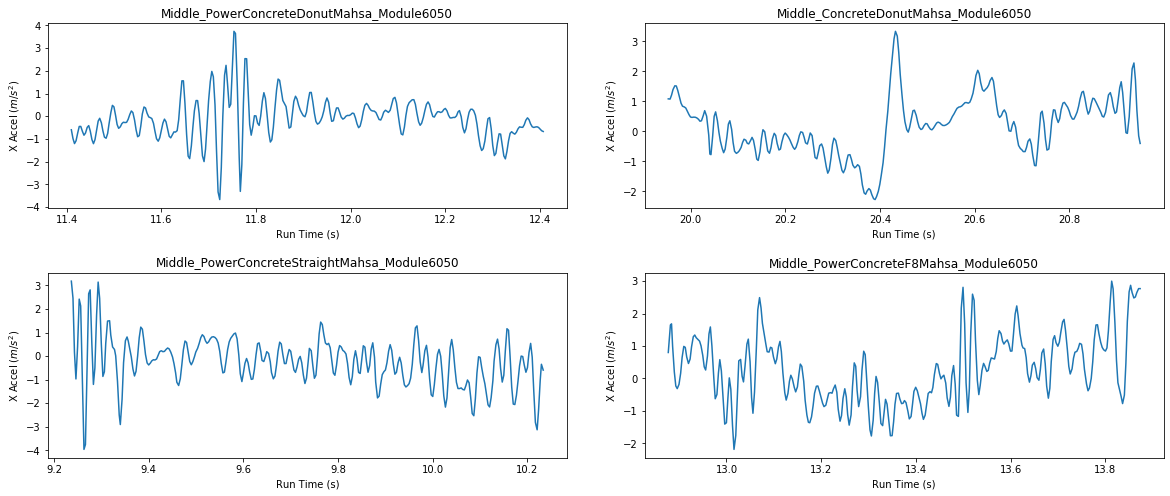

In [36]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='X Accel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [37]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [38]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [39]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 22
Num of FFT'd windows in first dataset: 66
Shape of FFT'd individual window: (60, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.895207,0.105916,0.029773,0.010181,0.002655,0.014727,0.0
1,0.212731,0.060899,0.048720,0.008744,0.031140,0.011436,1.0
2,0.067440,0.087533,0.023062,0.010255,0.018000,0.012449,2.0
3,0.145745,0.016038,0.051388,0.020609,0.025621,0.045910,3.0
4,0.090093,0.087300,0.140376,0.004942,0.004513,0.013368,4.0


<Figure size 432x288 with 0 Axes>

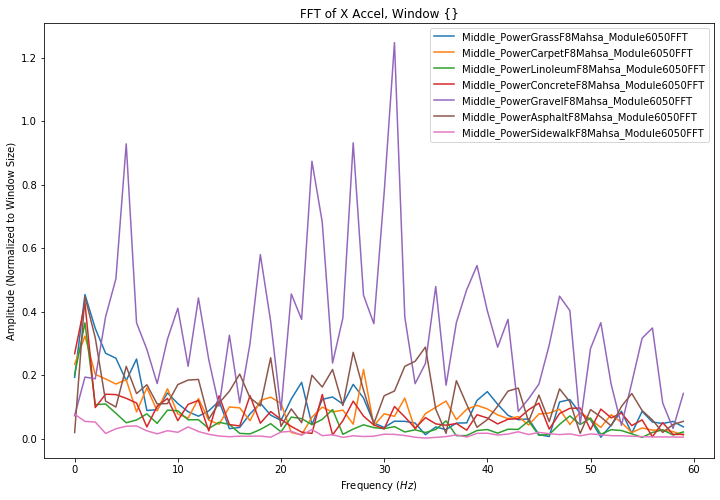

In [42]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=3, dirn=0, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

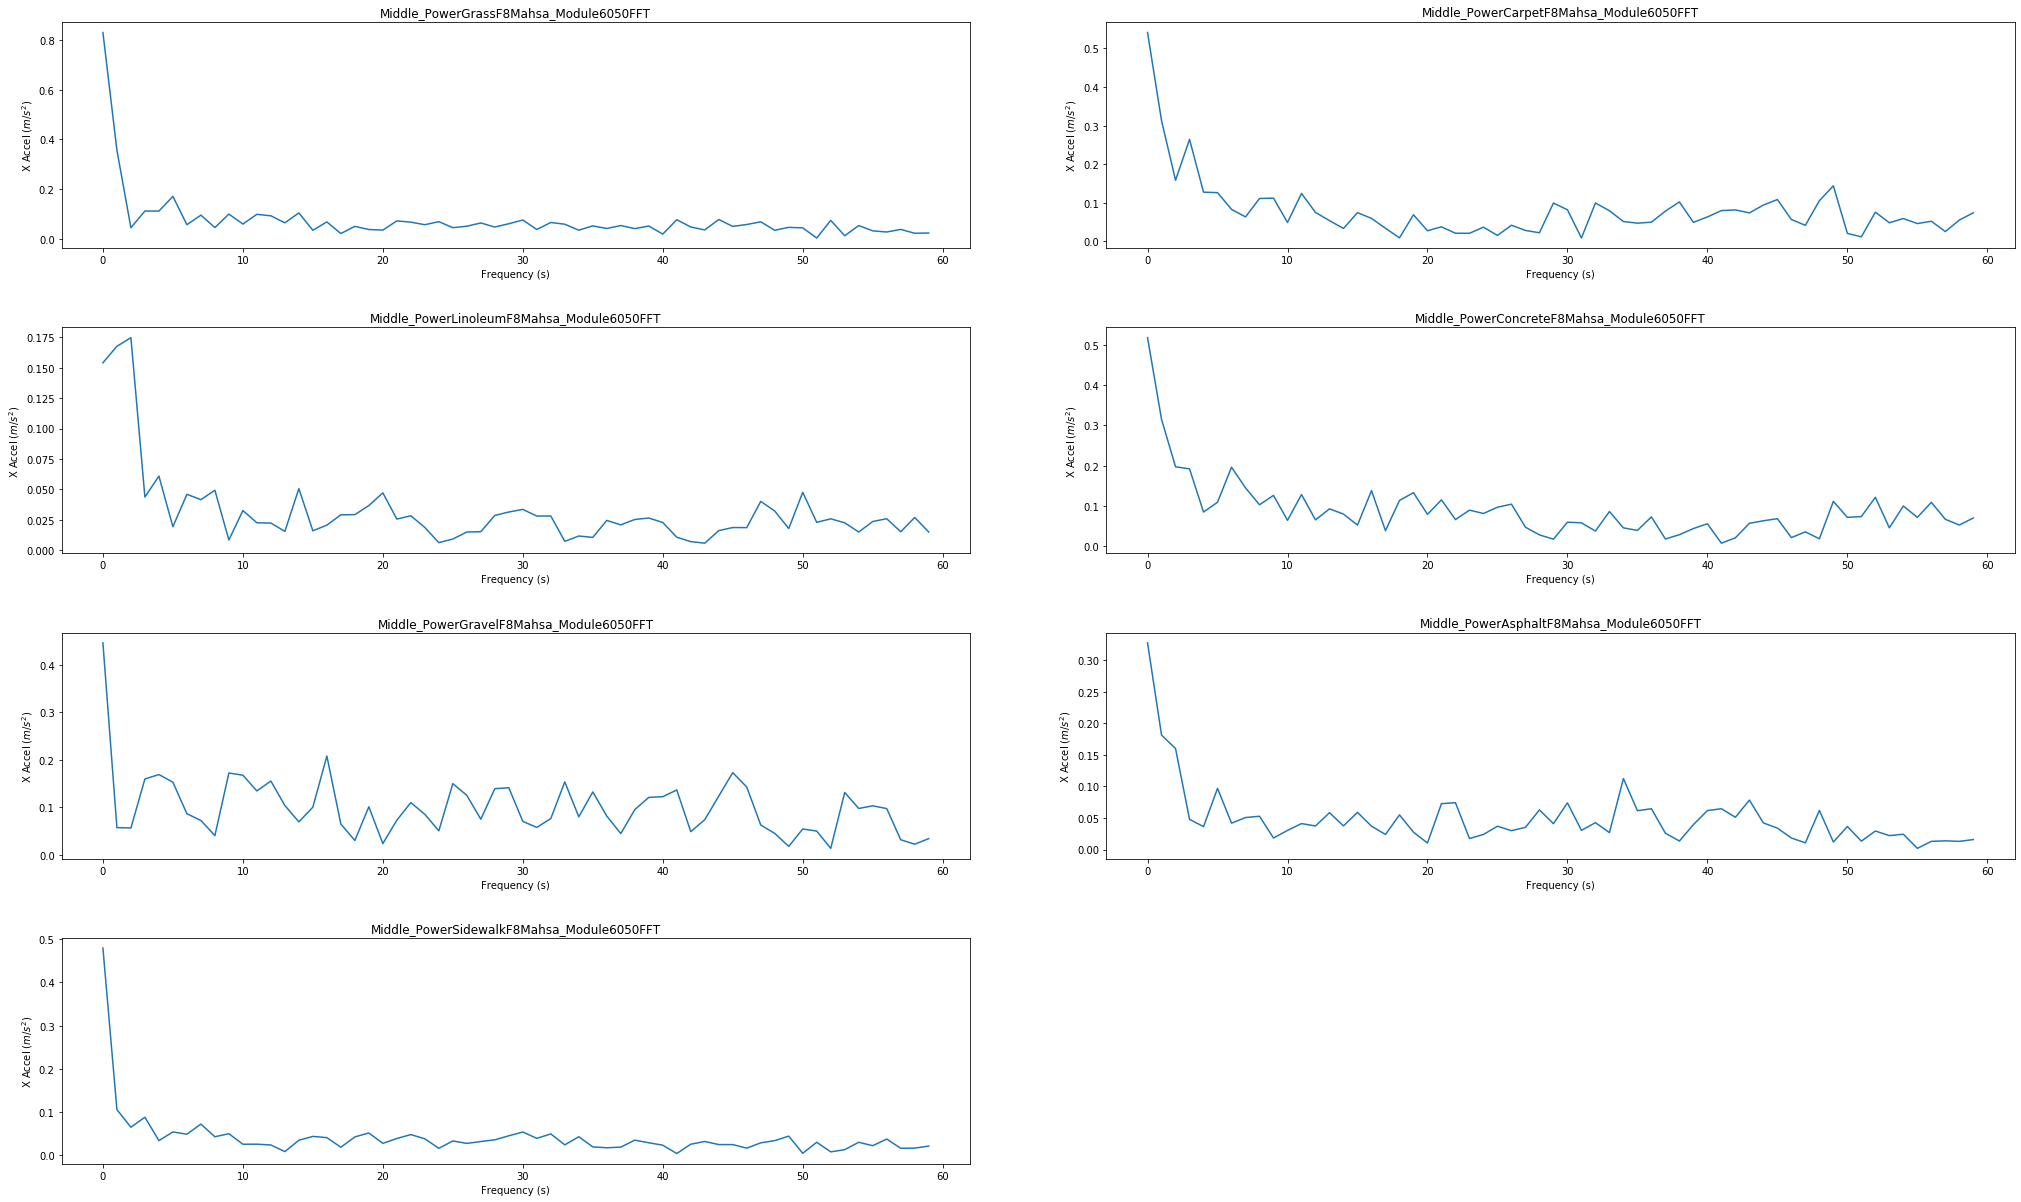

In [43]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='X Accel', windowed=True)

### Part (b) - PSD

In [44]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [47]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 22
Num of PSD'd windows in first dataset: 63
Shape of PSD'd individual window: (60, 7)


<Figure size 432x288 with 0 Axes>

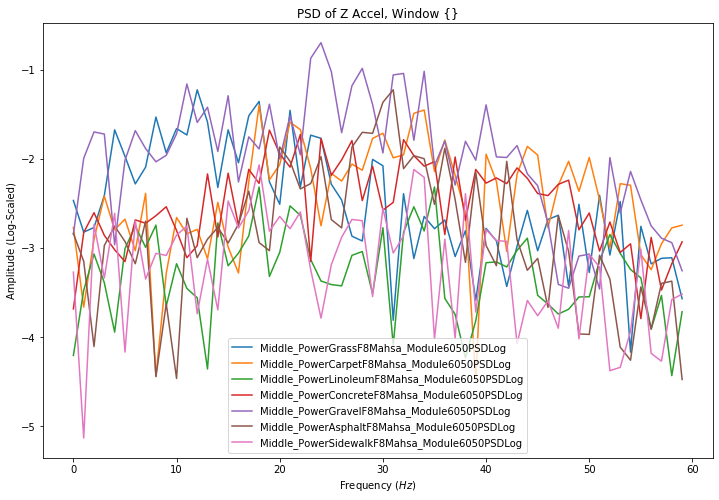

In [48]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

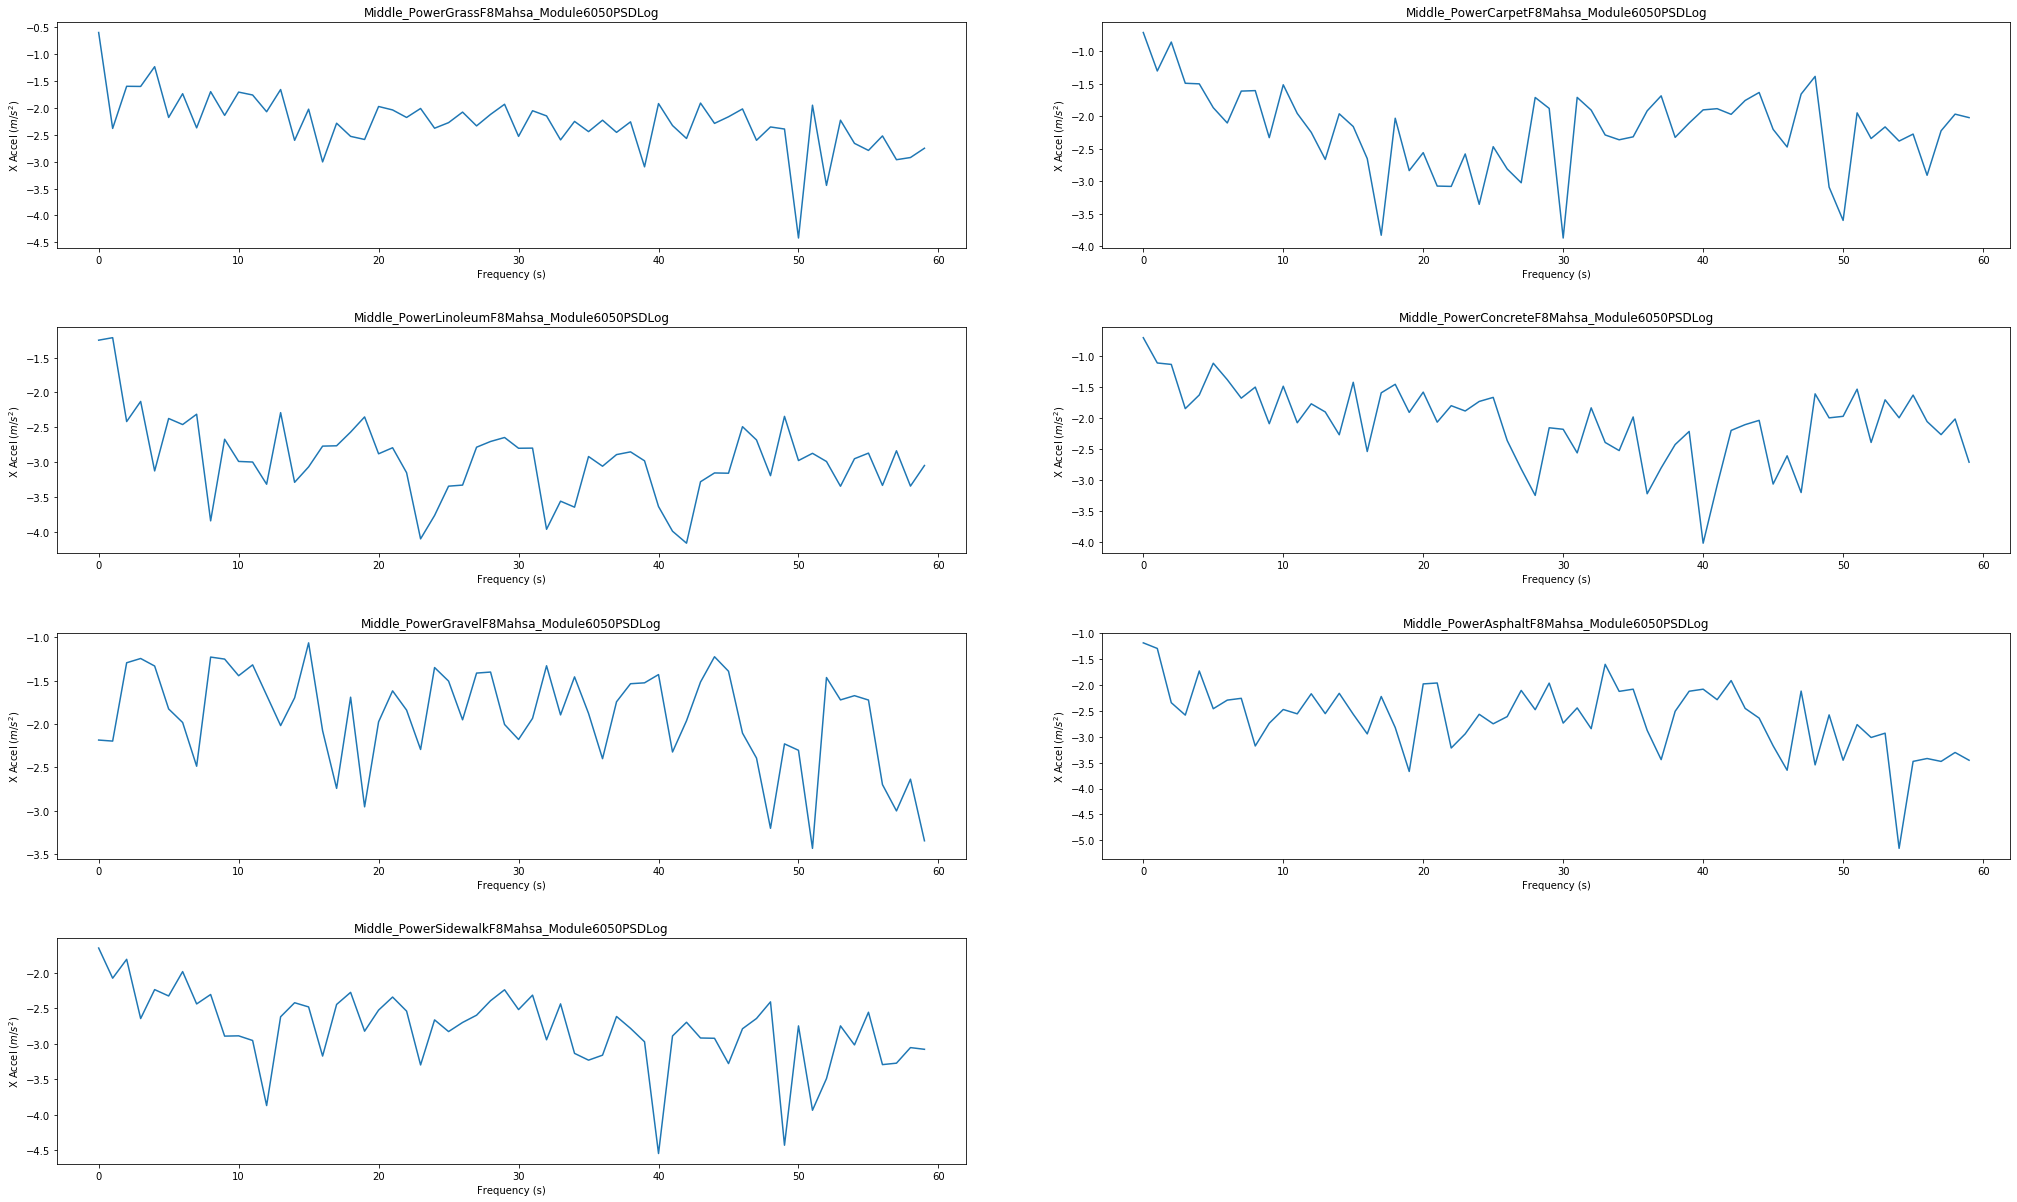

In [49]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Accel', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [50]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

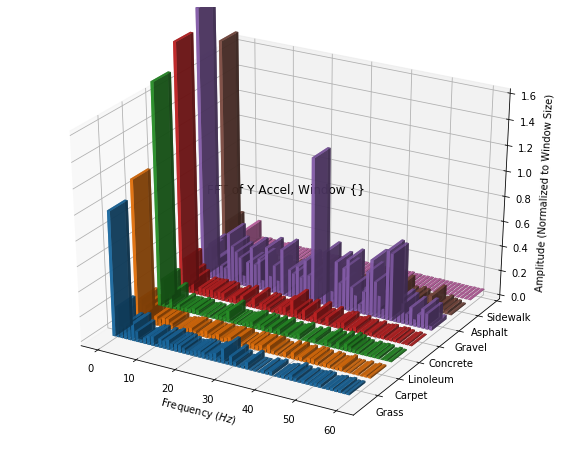

In [51]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=1, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

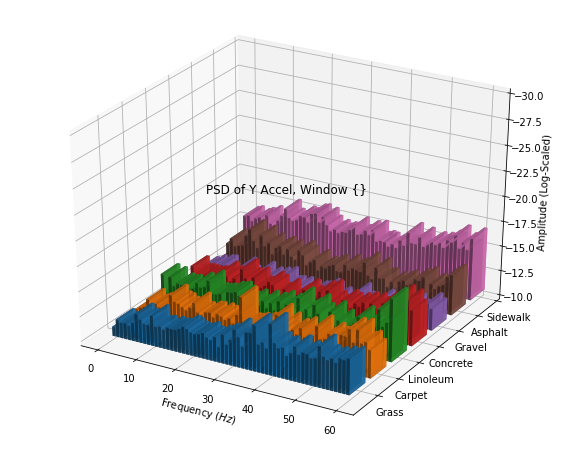

In [52]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=1, transform_name='PSD')

### Part (d) - Spectograms

In [53]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

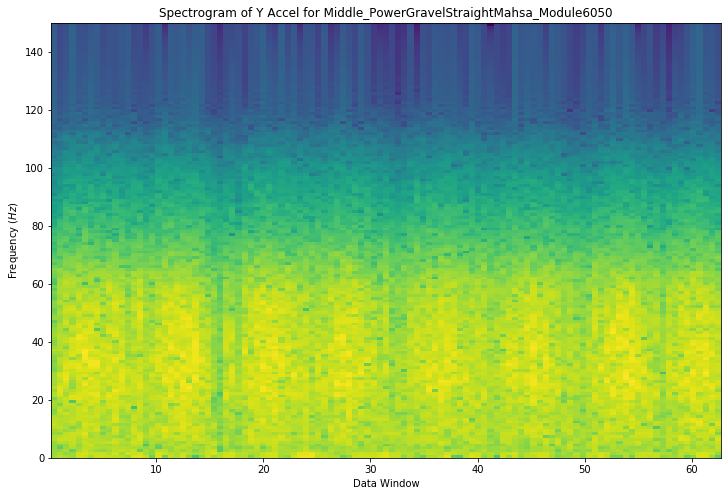

In [54]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [55]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [56]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [57]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [58]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [59]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Accel'].shape))

Num datasets: 22
Num directions: 6
Shape of first dataset first direction: (63, 10)


<Figure size 432x288 with 0 Axes>

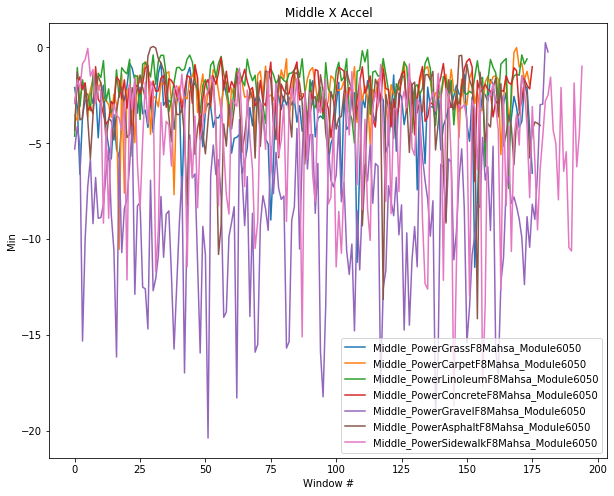

In [60]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [61]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [62]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Accel'].shape))

Num datasets: 22
Num directions: 6
Shape of one direction: (63, 5)


<Figure size 432x288 with 0 Axes>

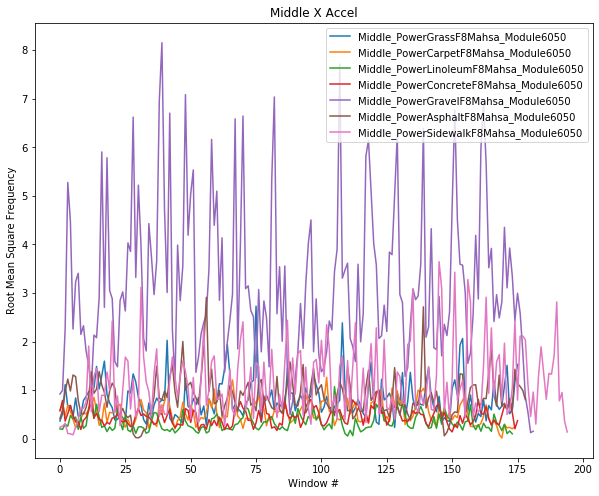

In [64]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [65]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [66]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [67]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [68]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,0.895207,1.429946,29.220582,853.842385,4.978742,-8.422158,1.687051,0.096667,-1.207505,5.957519,2.978400,1.725804,24.467352,-595.672931,1.725804
1,0.027961,3.797879,65.782984,4327.401030,12.033146,-10.178699,3.797982,0.160000,0.168812,0.282011,27.360172,5.230695,24.747777,-585.092283,5.230695
2,0.485369,4.332211,75.505564,5701.090123,12.255394,-13.429004,4.359316,0.176667,-0.047079,0.169627,17.369677,4.167694,24.203626,-568.445837,4.167694
3,-0.343065,6.052754,105.005027,11026.055686,14.318738,-16.509306,6.062468,0.186667,0.074003,-0.355510,54.791340,7.402117,26.557188,-650.492917,7.402117
4,-0.319259,6.027090,104.538611,10928.321175,13.070264,-17.439615,6.035540,0.183333,-0.368717,-0.158427,42.158951,6.492992,27.129663,-693.859642,6.492992


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [69]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [70]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [72]:
datasets_feat_norm[dataset_labels[0]]['X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,1.377221,-1.571389,-1.493559,-1.124654,-1.330929,0.803264,-1.493559,-2.776924,-3.133684,5.274777,-0.841950,-1.178677,0.239483,-0.551012,-1.178677
1,-0.008264,-0.277620,-0.316884,-0.454745,0.039015,0.496109,-0.316884,-0.394144,1.049363,-0.197828,-0.241398,-0.020287,0.357440,-0.447027,-0.020287
2,0.722476,0.014323,-0.003985,-0.189816,0.082175,-0.072252,-0.003985,0.232903,0.393204,-0.306194,-0.487476,-0.371616,0.128550,-0.283429,-0.371616
3,-0.601002,0.954376,0.945387,0.837153,0.482870,-0.610885,0.945387,0.609132,0.761210,-0.812558,0.434264,0.697383,1.118547,-1.089774,0.697383
4,-0.562971,0.940354,0.930376,0.818304,0.240420,-0.773562,0.930376,0.483722,-0.584351,-0.622520,0.123114,0.396911,1.359351,-1.515974,0.396911


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

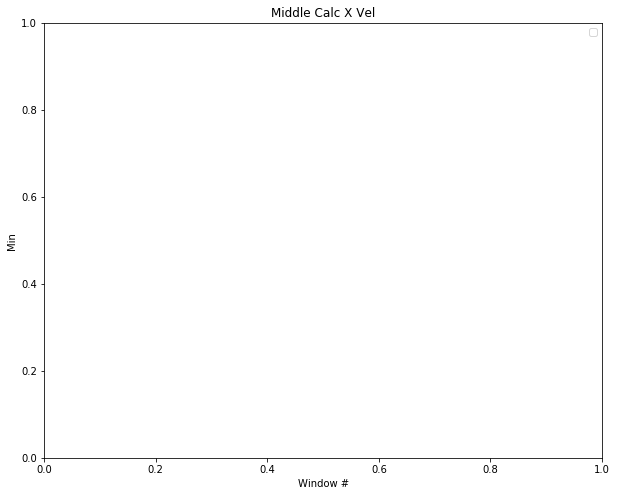

In [73]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Middle' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

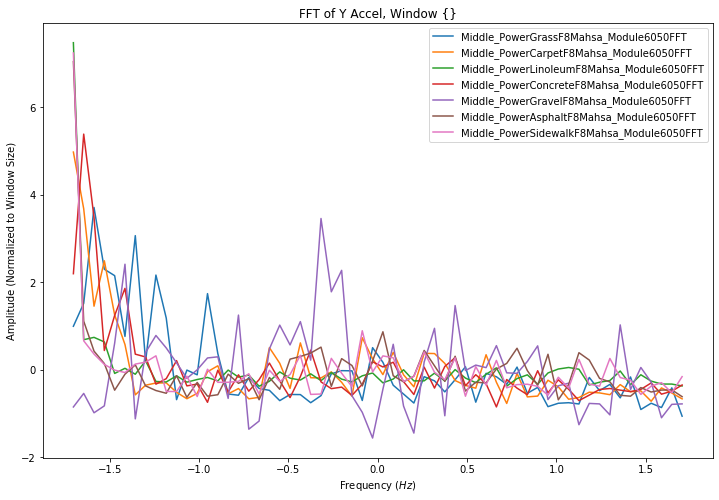

In [74]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [75]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [76]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [77]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,Excess Kurtosis X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,1.377221,-1.571389,-1.493559,-1.124654,-1.330929,0.803264,-1.493559,-2.776924,-3.133684,5.274777,...,0.414602,-0.830698,0.228753,1.188242,1.578922,-0.241841,-0.046230,-0.155422,0.298536,-0.046230
1,-0.008264,-0.277620,-0.316884,-0.454745,0.039015,0.496109,-0.316884,-0.394144,1.049363,-0.197828,...,0.083157,-0.647022,-0.316544,-0.021111,-0.574987,-1.140037,-1.427026,-0.402129,0.381604,-1.427026
2,0.722476,0.014323,-0.003985,-0.189816,0.082175,-0.072252,-0.003985,0.232903,0.393204,-0.306194,...,0.179643,-0.588881,-0.004946,0.027819,-0.717799,-0.621522,-0.501262,-0.174410,0.305915,-0.501262
3,-0.601002,0.954376,0.945387,0.837153,0.482870,-0.610885,0.945387,0.609132,0.761210,-0.812558,...,-0.534584,-0.374510,-0.394444,1.046257,0.628423,0.619324,0.749081,-0.048312,0.253715,0.749081
4,-0.562971,0.940354,0.930376,0.818304,0.240420,-0.773562,0.930376,0.483722,-0.584351,-0.622520,...,0.155336,-0.543730,-0.394444,-0.012453,0.485665,-0.073452,0.129237,0.015221,0.224554,0.129237


#### Part (ii) - Transformed Data

In [78]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in get_columns(label)[:get_n_data_col(label)]:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [79]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [80]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [81]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,FFT 58.0 Hz Z Accel Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
0,0.001155,0.002148,0.003852,0.045711,0.071169,0.054930,0.001325,0.001874,0.001657,0.047238,...,0.008744,0.048720,0.060899,0.212731,0.014727,0.002655,1.018072e-02,0.029773,0.105916,0.895207
1,0.002059,0.001882,0.002217,0.025444,0.089170,0.085339,0.002361,0.003453,0.002395,0.040057,...,0.011047,0.054065,0.091767,0.282235,0.016292,0.000951,1.878309e-02,0.170584,0.317259,0.027961
2,0.002288,0.002576,0.001248,0.038542,0.017296,0.082377,0.002342,0.004326,0.003652,0.037029,...,0.024824,0.049328,0.146235,0.426899,0.084981,0.017841,2.407799e-02,0.106610,0.303748,0.485369
3,0.000202,0.006869,0.004254,0.067346,0.066441,0.139696,0.004641,0.008368,0.009872,0.153859,...,0.031919,0.147417,0.328881,0.658299,0.238920,0.008311,3.881985e-03,0.049700,0.289348,0.343065
4,0.001975,0.007632,0.002749,0.046731,0.096154,0.185201,0.003681,0.006076,0.008153,0.085796,...,0.007116,0.086402,0.100329,0.317440,0.163348,0.004353,1.511682e-02,0.013386,0.409660,0.319259
5,0.004130,0.004063,0.012590,0.185176,0.303357,0.278782,0.004519,0.006125,0.012659,0.193307,...,0.016633,0.183351,0.113120,0.528187,0.177993,0.026287,1.228226e-02,0.206922,0.558093,0.053651
6,0.005392,0.009970,0.009020,0.051677,0.148875,0.210640,0.003753,0.004540,0.005552,0.042095,...,0.012746,0.157129,0.302337,0.374996,0.144455,0.039582,1.717046e-02,0.385976,0.010510,0.690016
7,0.008913,0.005985,0.007651,0.075281,0.127953,0.146907,0.007907,0.001459,0.004980,0.010287,...,0.022649,0.090649,0.415428,0.288141,0.715487,0.031946,2.055105e-02,0.049929,0.330294,0.881345
8,0.001883,0.003428,0.002234,0.077286,0.069376,0.208075,0.006683,0.007349,0.005304,0.128891,...,0.013150,0.065358,0.212574,0.327417,1.906611,0.054812,3.743602e-02,0.172649,0.949026,0.028069
9,0.002583,0.001717,0.002661,0.059687,0.090377,0.058032,0.003325,0.003897,0.004405,0.067790,...,0.010313,0.071466,0.122168,0.303431,0.236473,0.001090,1.607367e-02,0.055246,0.130299,0.782362


In [82]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,PSD 59.0 Hz Z Gyro Middle,PSD 59.0 Hz Y Gyro Middle,PSD 59.0 Hz X Gyro Middle,PSD 59.0 Hz Z Accel Middle,PSD 59.0 Hz Y Accel Middle,PSD 59.0 Hz X Accel Middle,PSD 58.0 Hz Z Gyro Middle,PSD 58.0 Hz Y Gyro Middle,PSD 58.0 Hz X Gyro Middle,PSD 58.0 Hz Z Accel Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
0,-6.174987,-4.962720,-4.612492,-2.420759,-2.205620,-2.416285,-5.573957,-5.034810,-4.527680,-2.378936,...,-3.677109,-2.973184,-1.814624,-2.041134,-3.582426,-2.712330,-3.815548,-2.323563,-2.129744,-1.043310
1,-4.209943,-4.834353,-3.575284,-2.774822,-0.922649,-3.212904,-5.071461,-5.149552,-5.007583,-2.887793,...,-3.087593,-2.650304,-1.717831,-0.636388,-1.609559,-3.088868,-3.612476,-2.233137,-1.773601,-0.797747
2,-4.322926,-4.135615,-4.015511,-1.525553,-1.497563,-2.062105,-4.979954,-4.876991,-5.506731,-2.527110,...,-3.711551,-2.887562,-1.458834,-0.901330,-1.673702,-3.238342,-2.909218,-2.312787,-1.368869,-0.438320
3,-6.737175,-3.898917,-4.880695,-2.232953,-2.292228,-1.590563,-7.086150,-4.025174,-4.441399,-2.042344,...,-2.543833,-1.580599,-1.117578,-0.747585,-1.601171,-2.197824,-2.690879,-1.361877,-0.664891,-0.062124
4,-4.569521,-4.188895,-4.030367,-2.434832,-1.539283,-1.512371,-5.107805,-3.933687,-4.820624,-2.359766,...,-3.215790,-1.530539,-4.635817,-1.090574,-1.791007,-2.782722,-3.994542,-1.825926,-1.696113,-0.695647
5,-5.206775,-3.962654,-4.449324,-1.880547,-1.565261,-1.336486,-4.467165,-4.481251,-3.498919,-1.163801,...,-2.961608,-0.861876,-1.911684,-1.187877,-2.964964,-2.664162,-3.257021,-1.172405,-1.591893,-0.253395
6,-5.934279,-4.827890,-4.461152,-2.393248,-1.950299,-1.779642,-4.235533,-3.701592,-3.788531,-2.272368,...,-3.673450,-1.250990,-1.478780,-0.847296,-1.967744,-2.658503,-3.488255,-1.306460,-0.737987,-0.550917
7,-3.942080,-4.176760,-4.030476,-2.083477,-1.499455,-1.869868,-3.798962,-4.144823,-3.931492,-1.945602,...,-2.979076,-1.385515,-1.287636,-0.778571,-0.401053,-2.999805,-2.988857,-1.784245,-0.461978,-0.779759
8,-4.270799,-4.179834,-4.767932,-1.672499,-1.472683,-0.948546,-5.149079,-4.628957,-5.000940,-1.922764,...,-4.458420,-1.194263,-1.037720,-0.740132,-1.221798,-2.973492,-3.461102,-2.068368,-1.043950,-0.668767
9,-4.829718,-5.139641,-5.906790,-2.671246,-2.147775,-1.929024,-4.874787,-5.229262,-4.848891,-2.147205,...,-2.953752,-2.420281,-1.983598,-0.846208,-1.088712,-2.990971,-3.672234,-1.990765,-1.525058,-0.734851


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [94]:
#datasets_feat_columned.update({'Middle_PowerAsphaltDonutMahsa_Module6050': datasets_feat_columned.pop('Middle_PowerAphaltDonutMahsa_Module6050')})
#datasets_fft_columned.update({'Middle_PowerAsphaltDonutMahsa_Module6050FFT': datasets_fft_columned.pop('Middle_PowerAphaltDonutMahsa_Module6050FFT')})
#datasets_psd_log_columned.update({'Middle_PowerAsphaltDonutMahsa_Module6050PSDLog': datasets_psd_log_columned.pop('Middle_PowerAphaltDonutMahsa_Module6050PSDLog')})

In [95]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [96]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

Middle_PowerGravelStraightMahsa_Module6050
Middle_PowerConcreteDonutMahsa_Module6050
Middle_PowerGrassF8Mahsa_Module6050
Middle_PowerLinoleumDonutMahsa_Module6050
Middle_PowerSidewalkStraightMahsa_Module6050
Middle_PowerLinoleumStraightMahsa_Module6050
Middle_ConcreteDonutMahsa_Module6050
Middle_PowerCarpetF8Mahsa_Module6050
Middle_PowerLinoleumF8Mahsa_Module6050
Middle_PowerCarpetStraightMahsa_Module6050
Middle_PowerAsphaltStraightMahsa_Module6050
Middle_PowerCarpetDonutMahsa_Module6050
Middle_PowerConcreteStraightMahsa_Module6050
Middle_PowerGrassStraightMahsa_Module6050
Middle_PowerGravelDonutMahsa_Module6050
Middle_PowerConcreteF8Mahsa_Module6050
Middle_PowerGravelF8Mahsa_Module6050
Middle_PowerSidewalkDonutMahsa_Module6050
Middle_PowerAsphaltF8Mahsa_Module6050
Middle_PowerGrassDonutMahsa_Module6050
Middle_PowerSidewalkF8Mahsa_Module6050
Middle_PowerAsphaltDonutMahsa_Module6050
Middle_PowerGravelStraightMahsa_Module6050FFT
Middle_PowerConcreteDonutMahsa_Module6050FFT
Middle_PowerGr

In [97]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,6,1.377221,-1.571389,-1.493559,-1.124654,-1.330929,0.803264,-1.493559,-2.776924,-3.133684,...,0.414602,-0.830698,0.228753,1.188242,1.578922,-0.241841,-0.046230,-0.155422,0.298536,-0.046230
1,6,-0.008264,-0.277620,-0.316884,-0.454745,0.039015,0.496109,-0.316884,-0.394144,1.049363,...,0.083157,-0.647022,-0.316544,-0.021111,-0.574987,-1.140037,-1.427026,-0.402129,0.381604,-1.427026
2,6,0.722476,0.014323,-0.003985,-0.189816,0.082175,-0.072252,-0.003985,0.232903,0.393204,...,0.179643,-0.588881,-0.004946,0.027819,-0.717799,-0.621522,-0.501262,-0.174410,0.305915,-0.501262
3,6,-0.601002,0.954376,0.945387,0.837153,0.482870,-0.610885,0.945387,0.609132,0.761210,...,-0.534584,-0.374510,-0.394444,1.046257,0.628423,0.619324,0.749081,-0.048312,0.253715,0.749081
4,6,-0.562971,0.940354,0.930376,0.818304,0.240420,-0.773562,0.930376,0.483722,-0.584351,...,0.155336,-0.543730,-0.394444,-0.012453,0.485665,-0.073452,0.129237,0.015221,0.224554,0.129237


In [98]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].head()

,Label,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
0,6,0.001155,0.002148,0.003852,0.045711,0.071169,0.054930,0.001325,0.001874,0.001657,...,0.008744,0.048720,0.060899,0.212731,0.014727,0.002655,0.010181,0.029773,0.105916,0.895207
1,6,0.002059,0.001882,0.002217,0.025444,0.089170,0.085339,0.002361,0.003453,0.002395,...,0.011047,0.054065,0.091767,0.282235,0.016292,0.000951,0.018783,0.170584,0.317259,0.027961
2,6,0.002288,0.002576,0.001248,0.038542,0.017296,0.082377,0.002342,0.004326,0.003652,...,0.024824,0.049328,0.146235,0.426899,0.084981,0.017841,0.024078,0.106610,0.303748,0.485369
3,6,0.000202,0.006869,0.004254,0.067346,0.066441,0.139696,0.004641,0.008368,0.009872,...,0.031919,0.147417,0.328881,0.658299,0.238920,0.008311,0.003882,0.049700,0.289348,0.343065
4,6,0.001975,0.007632,0.002749,0.046731,0.096154,0.185201,0.003681,0.006076,0.008153,...,0.007116,0.086402,0.100329,0.317440,0.163348,0.004353,0.015117,0.013386,0.409660,0.319259


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [99]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [100]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [101]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Mahsa_Power')

feat_combined['Middle'].tail()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
2164,3,-1.126572,0.424742,0.387467,0.178925,0.623260,0.235609,0.387467,-0.061161,1.214306,...,0.921098,0.069563,-0.127,0.089422,-0.983848,-0.288748,-0.296445,-0.338694,0.341499,-0.296445
2165,3,-0.588483,-0.136424,-0.198960,-0.318336,-0.059482,0.193594,-0.198960,-0.774704,0.757073,...,0.840151,-0.219364,-0.127,1.127261,1.014379,1.094327,1.715763,1.340716,-0.744721,1.715763
2166,3,-1.490103,-0.666548,-0.624511,-0.609363,-0.479324,0.513408,-0.624511,-1.060121,1.178308,...,0.736654,-1.018714,-0.127,-0.572848,-0.752103,-0.440181,-0.983096,-0.432959,0.364952,-0.983096
2167,3,0.191780,-0.576278,-0.616766,-0.604591,-0.555568,0.422258,-0.616766,-1.773664,-0.708670,...,0.623496,-1.372115,-0.127,1.286244,-0.244252,-0.391205,-0.669259,-0.718030,0.411741,-0.669259
2168,3,-0.513519,-1.360531,-1.417987,-0.995189,-1.120245,1.003544,-1.417987,0.652382,-0.429179,...,0.512163,-1.628647,-0.127,1.243623,-0.526091,-0.119714,0.115310,-0.238542,0.312216,0.115310


In [102]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Mahsa_Power')

fft_combined['Middle'].tail()

,Label,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
2164,3,0.000452,0.001334,0.003869,0.030370,0.088971,0.064864,0.001634,0.000477,0.002482,...,0.012157,0.118315,0.285965,0.200978,1.055743,0.051783,0.031576,0.066769,1.505099,0.231139
2165,3,0.002403,0.001175,0.002100,0.005780,0.024242,0.036936,0.002488,0.000456,0.001139,...,0.005692,0.020975,0.037540,0.307531,0.985604,0.035431,0.030483,0.010977,1.467795,0.070205
2166,3,0.000430,0.000208,0.003529,0.006958,0.044335,0.010851,0.000379,0.000927,0.001166,...,0.003436,0.028574,0.058761,0.121606,0.769733,0.018630,0.020167,0.026163,1.136589,0.339865
2167,3,0.000372,0.000533,0.000822,0.005769,0.019322,0.007362,0.000604,0.001624,0.000357,...,0.004979,0.042360,0.128033,0.421979,0.655797,0.025253,0.016816,0.094383,0.692938,0.163160
2168,3,0.001994,0.001406,0.001152,0.004639,0.016670,0.010678,0.001645,0.000116,0.000877,...,0.004667,0.015171,0.140773,0.113673,0.575199,0.023098,0.015045,0.048738,0.570459,0.047784


In [103]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Mahsa_Power')

psd_log_combined['Middle'].tail()

,Label,PSD 59.0 Hz Z Gyro Middle,PSD 59.0 Hz Y Gyro Middle,PSD 59.0 Hz X Gyro Middle,PSD 59.0 Hz Z Accel Middle,PSD 59.0 Hz Y Accel Middle,PSD 59.0 Hz X Accel Middle,PSD 58.0 Hz Z Gyro Middle,PSD 58.0 Hz Y Gyro Middle,PSD 58.0 Hz X Gyro Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
2164,3,-5.242839,-5.322115,-5.277850,-4.674089,-3.151739,-2.257273,-6.387744,-5.448763,-4.523775,...,-4.277225,-1.518583,-2.633451,-1.687240,-1.408134,-3.918681,-3.529341,-1.552889,-0.786345,-1.092672
2165,3,-5.279456,-5.309703,-5.230109,-3.297485,-2.494721,-2.661800,-4.937288,-5.558717,-5.054571,...,-4.369730,-2.472707,-2.765379,-1.299711,-2.252978,-4.087791,-4.188438,-3.055564,-2.549982,-0.723191
2166,3,-6.276937,-5.920786,-8.508388,-3.285934,-5.112639,-2.677991,-6.431611,-7.062402,-4.603733,...,-4.225982,-2.630253,-2.308321,-2.311234,-1.877723,-4.738974,-4.626944,-2.787032,-2.160790,-1.529061
2167,3,-6.352192,-5.127207,-5.976403,-3.830441,-3.930919,-2.687120,-6.557801,-6.246313,-5.869329,...,-4.141764,-2.851877,-2.669059,-1.642406,-1.502528,-3.735189,-4.304762,-2.445064,-1.484323,-0.448388
2168,3,-5.067597,-5.728875,-5.649900,-4.052189,-2.950125,-3.748629,-5.099634,-5.402902,-5.575831,...,-4.455029,-4.012228,-2.212077,-2.255347,-1.507463,-3.593982,-4.360976,-3.336949,-1.401934,-1.587654


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right